In [1]:
# declare imports
import argparse
from datetime import datetime
from pathlib import Path
import os
import sys
import dask.dataframe as dd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


path_to_functions = os.path.abspath("../src")

# Add this folder to the system path
sys.path.append(path_to_functions)

from pearl.post_processing.bmi import (
    add_summary,
    calc_overall_risk,
    calc_percentage,
    calc_percentage_and_add_summary,
    calc_risk_by_group,
    clean_control,
    create_summary_table,
    group_order,
    group_order_with_sub_total,
    group_title_dict,
    palette,
    rearrange_group_order,
    round_thousand,
    calc_dm_prop,
    add_sub_total
)

# Define the argument parser

baseline_dir = Path('../out/S0_10/combined')
variable_dir = Path('../out/S3_10/combined')
out_dir = Path('../results')

C:\Users\jackz\.conda\envs\PEARL\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
start_time = datetime.now()
df_summary_dict = {}

start_year = 2013
end_year = 2017

##############################################################################################################################
num_samples = 2000

# we will look at the "bmi_int_dm_prev.h5" for S1
bmi_int_dm_prev_s1 = dd.read_parquet(variable_dir / "dm_final_output.parquet").reset_index()

bmi_int_dm_prev_s1 = bmi_int_dm_prev_s1.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# Add Overall
all_but_group = list(bmi_int_dm_prev_s1.columns[1:])
bmi_int_dm_prev_s1_overall = bmi_int_dm_prev_s1.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_s1_overall["group"] = "overall"
bmi_int_dm_prev_s1 = dd.concat(
    [bmi_int_dm_prev_s1, bmi_int_dm_prev_s1_overall], ignore_index=True
)

# clean to control specifications
control_bmi_int_dm_prev_s1 = clean_control(bmi_int_dm_prev_s1, only_eligible=True, only_received=True)

# filter for only people eligible for intervention
bmi_int_s1_eligible_risk = calc_risk_by_group(control_bmi_int_dm_prev_s1, 7)

s1_sample = (
    bmi_int_s1_eligible_risk.groupby("group")
    .apply(lambda x: x.sample(num_samples, replace=True))
    .reset_index(drop=True)
    .compute()
)

del bmi_int_dm_prev_s1, bmi_int_s1_eligible_risk

# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "dm_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

bmi_int_eligible_risk = calc_risk_by_group(control_bmi_int_dm_prev, 7)

s0_sample = (
    bmi_int_eligible_risk.groupby("group")
    .apply(lambda x: x.sample(num_samples, replace=True))
    .reset_index(drop=True)
    .compute()
)

del bmi_int_dm_prev, bmi_int_eligible_risk

s0_sample = s0_sample.sort_values(by="group").reset_index(drop=True)
s1_sample = s1_sample.sort_values(by="group").reset_index(drop=True)

# absolute difference
abs_sample_diff = s1_sample[["dm_num", "risk"]] - s0_sample[["dm_num", "risk"]]
abs_sample_diff["group"] = s0_sample["group"]
abs_sample_diff["num"] = s0_sample["num"]

abs_sample_diff_plot = abs_sample_diff.copy()
abs_sample_diff_plot["group"] = abs_sample_diff_plot["group"].map(group_title_dict)
abs_sample_diff_plot["dm_num_prevented"] = abs_sample_diff_plot["dm_num"] * -1

# relative difference
rel_sample_diff = -(s1_sample[["risk"]] - s0_sample[["risk"]]) / s0_sample[["risk"]]
rel_sample_diff["group"] = s0_sample["group"]

rel_sample_diff_plot = rel_sample_diff.copy()
rel_sample_diff_plot["group"] = rel_sample_diff_plot["group"].map(group_title_dict)

C:\Users\jackz\AppData\Local\Temp\ipykernel_31340\2692544347.py:43: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  .apply(lambda x: x.sample(num_samples, replace=True))
C:\Users\jackz\AppData\Local\Temp\ipykernel_31340\2692544347.py:81: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  .apply(lambda x: x.sample(num_samples, replace=True))


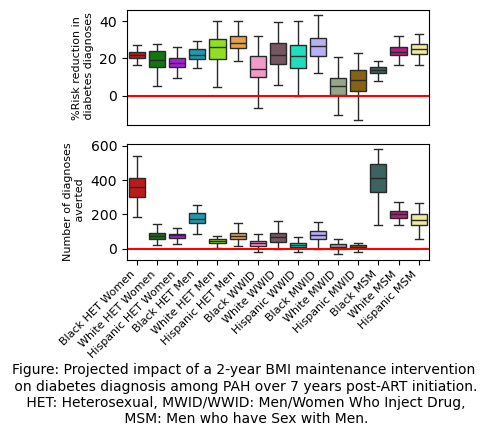

In [45]:
# Create the subplots with a 2x1 grid, adjusting the figure size to 4x4 inches
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 4))

# Plot 1: Relative risk reduction (top plot)
sns.boxplot(
    x=rel_sample_diff_plot["group"],
    y=rel_sample_diff_plot["risk"]*100,
    color="seagreen",
    showfliers=False,
    palette=palette,
    hue=rel_sample_diff_plot["group"],
    order=group_order[:-1],
    hue_order=group_order,
    ax=ax1  # Specify the first axis (top panel)
)

ax1.tick_params(axis="x", bottom=False, labelbottom=False)  # Hide x-axis labels and ticks for the top plot
ax1.set_xlabel("")  
ax1.set_ylabel("%Risk reduction in\n diabetes diagnoses",fontsize = 8) 
ax1.axhline(y=0, color="r", linestyle="-")
# ax1.set_title("%Risk reduction in diabetes diagnoses",fontsize = 6) 
# ax1.text(-0.05, 0.5, '(A)', transform=ax1.transAxes, fontsize=12, verticalalignment='center')


# Plot 2: Number of DM diagnoses averted (bottom plot)
sns.boxplot(
    x=abs_sample_diff_plot["group"],
    y=abs_sample_diff_plot["dm_num_prevented"],
    color="seagreen",
    showfliers=False,
    palette=palette,
    hue=abs_sample_diff_plot["group"],
    order=group_order[:-1],
    hue_order=group_order,
    ax=ax2  # Specify the second axis (bottom panel)
)
# ax2.text(-0.05, 0.5, '(B)', transform=ax2.transAxes, fontsize=12, verticalalignment='center')

ax2.tick_params(axis="x", rotation=45, labeltop=False, labelbottom=True, labelsize = 8)
for label in ax2.get_xticklabels():
    label.set_ha('right')  # Horizontal alignment to right
    label.set_va('top')    # Vertical alignment to top
    
ax2.set_xlabel("")
ax2.set_ylabel("Number of diagnoses\n averted",fontsize = 8)
ax2.axhline(y=0, color="r", linestyle="-")
# ax2.set_title("Number of diagnoses averted",fontsize = 6)

# Adjust layout to ensure labels and titles don't overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.text(0.5, -0.12, 'Figure: Projected impact of a 2-year BMI maintenance intervention\n on diabetes diagnosis among PAH over 7 years post-ART initiation.\n HET: Heterosexual, MWID/WWID: Men/Women Who Inject Drug,\n MSM: Men who have Sex with Men.', ha='center', fontsize=10)

# Display the figure
plt.show()
fig.savefig(out_dir/'CORI_figure.png', bbox_inches = 'tight', dpi=1000)